# INFO 3401 – Class 18: Temporal patterns and autocorrelation

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning Objectives
This lecture will introduce the final fundamental concepts for working with temporal data.

* Common types of temporal patterns found in data (human behavior and otherwise)
* Identifying and characterizing autocorrelation in temporal data
* Using the `Grouper` function with temporal data to perform more advanced groupby-aggregations

## Background

This week we've covered a lot of ground around different functions, methods, and attributes for working with temporal data in pandas as well as a variety of different datasets. This lecture is going to focus on finding common patterns in temporal data as well as the implications these patterns have for forecasting and prediction, which we will discuss more next week.

## Load libraries

In [2]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## Revisit groupby-aggregation with temporal data: `Grouper`

During the in-class lecture for Class 17, I encountered a problem where I was trying to extract `datetime.date` objects and cast them to pandas's `Period` objects to measure how NYC taxi activity changed between February through April 2020. It wasn't very clear and it turns out it was pretty inelegant compared to a functionality that pandas has introduced recently and I wasn't aware of: the [`Grouper`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html) function.

To review, let's read in the NYC yellow cab taxi data again. I'm doing this from disk, but you could read in from the website: https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-03.csv

In [2]:
# Read in and parse the pickup and dropoff times to dates immediately
yellow_df = pd.read_csv('yellow_tripdata_2020-03.csv',
                        parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

# Rename the long datetime columns to something shorter
yellow_df.rename(columns={'tpep_pickup_datetime':'PU_timestamp',
                          'tpep_dropoff_datetime':'DO_timestamp'}
                 ,inplace=True)

# Inspect
yellow_df.head()

/Users/briankeegan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,VendorID,PU_timestamp,DO_timestamp,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.70,1.0,N,88,255,1.0,22.0,3.0,0.5,2.00,0.0,0.3,27.80,2.5
1,2.0,2020-03-01 00:08:22,2020-03-01 00:08:49,1.0,0.00,1.0,N,193,193,2.0,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0
2,1.0,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.10,1.0,N,246,90,1.0,6.0,3.0,0.5,1.95,0.0,0.3,11.75,2.5
3,2.0,2020-03-01 00:47:53,2020-03-01 00:50:57,2.0,0.87,1.0,N,151,238,1.0,5.0,0.5,0.5,1.76,0.0,0.3,10.56,2.5
4,1.0,2020-03-01 00:43:19,2020-03-01 00:58:27,0.0,4.40,1.0,N,79,261,1.0,16.5,3.0,0.5,4.05,0.0,0.3,24.35,2.5


In [3]:
yellow_df.loc[0,'PU_timestamp']

Timestamp('2020-03-01 00:31:13')

Also made a "ride ID" column that is just the index so we can get counts of the number of unique rides as distinct from the count of passengers.

In [4]:
yellow_df['ride_id'] = yellow_df.index

yellow_df.head()

,VendorID,PU_timestamp,DO_timestamp,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,ride_id
0,1.0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.70,1.0,N,88,255,1.0,22.0,3.0,0.5,2.00,0.0,0.3,27.80,2.5,0
1,2.0,2020-03-01 00:08:22,2020-03-01 00:08:49,1.0,0.00,1.0,N,193,193,2.0,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0,1
2,1.0,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.10,1.0,N,246,90,1.0,6.0,3.0,0.5,1.95,0.0,0.3,11.75,2.5,2
3,2.0,2020-03-01 00:47:53,2020-03-01 00:50:57,2.0,0.87,1.0,N,151,238,1.0,5.0,0.5,0.5,1.76,0.0,0.3,10.56,2.5,3
4,1.0,2020-03-01 00:43:19,2020-03-01 00:58:27,0.0,4.40,1.0,N,79,261,1.0,16.5,3.0,0.5,4.05,0.0,0.3,24.35,2.5,4


What I was trying to do before was turn the "PU_timestamp" column into a date column, so that I could group on that new date column.

In [7]:
yellow_df['date'] = yellow_df['PU_timestamp'].apply(lambda x:x.date())
yellow_df.head()

,VendorID,PU_timestamp,DO_timestamp,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,ride_id,date
0,1.0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.70,1.0,N,88,255,1.0,22.0,3.0,0.5,2.00,0.0,0.3,27.80,2.5,0,2020-03-01
1,2.0,2020-03-01 00:08:22,2020-03-01 00:08:49,1.0,0.00,1.0,N,193,193,2.0,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0,1,2020-03-01
2,1.0,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.10,1.0,N,246,90,1.0,6.0,3.0,0.5,1.95,0.0,0.3,11.75,2.5,2,2020-03-01
3,2.0,2020-03-01 00:47:53,2020-03-01 00:50:57,2.0,0.87,1.0,N,151,238,1.0,5.0,0.5,0.5,1.76,0.0,0.3,10.56,2.5,3,2020-03-01
4,1.0,2020-03-01 00:43:19,2020-03-01 00:58:27,0.0,4.40,1.0,N,79,261,1.0,16.5,3.0,0.5,4.05,0.0,0.3,24.35,2.5,4,2020-03-01


The problem was that the `datetime.date` objects are not the same as the pandas `Timestamp` objects. This becomes important when we want to filter out the weird out-of-scope data about pickups from 2008 or August 2020 in the resulting aggregation. We can't use the helpful slice notation because they are not supported by the `datetime.date` objects but slicing is supported by pandas `Timestamp` and `Period` objects.

This is a summary of the **bad** way I was demonstrating on Wednesday. It's not wrong, it's just painful, confusing, and prone to errors. Because programmers and data scientists are lazy and we want computers to do the hard work for us, we should find faster and more elegant solutions.

In [10]:
daily_rides_df = yellow_df.groupby('date').agg({'ride_id':'nunique'})
daily_rides_df.loc['2020-03-01':'2020-03-31']

TypeError: '<' not supported between instances of 'datetime.date' and 'str'

So then I was trying to convert the datetime to pandas objects and it just became a lot of extra work which was hard for me to explain and confusing for you all encountering it the first time. 

My bad: I apologize.

But I found a better way *and* I learned something new that I'm going to use in my research! **#DataScienceMindset**

![Grouper from NOAA Fisheries](https://cdn2.webdamdb.com/1280_kxYo2rHyNqh7.jpg?1561575783)

The `Grouper` function provides some advanced functionality for working with temporal data and lets us skip those confusing steps of extracting to a new column, groupby-aggregation, recasting the index, *etc.*

The `Grouper` function is a helper function that doesn't do much of anything on its own, but makes the groupby method much more powerful, especially with temporal data. We pass the `Grouper` function inside the `groupby` method on the DataFrame we're analyzing and tell it the column we want it to group on. We'll use one of the temporal columns and we'll also pass a frequency, starting with daily ("1D").

In [11]:
yellow_df.head(2)

,VendorID,PU_timestamp,DO_timestamp,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,ride_id,date
0,1.0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.7,1.0,N,88,255,1.0,22.0,3.0,0.5,2.0,0.0,0.3,27.8,2.5,0,2020-03-01
1,2.0,2020-03-01 00:08:22,2020-03-01 00:08:49,1.0,0.0,1.0,N,193,193,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0,1,2020-03-01


In [15]:
yellow_gb = yellow_df.groupby(pd.Grouper(key='PU_timestamp',freq='1D'))
yellow_gb

Again, the groupby—even with the powerful Grouper function inside—doesn't do much solo. We also need to pass an aggregation function to summarize the data in different columns in specific ways. Write an aggregation dictionary that gets the number of unique rides, the total "passenger_count", the average "total_fare", and the average "trip_distance".

In [16]:
agg_d = {'ride_id':'nunique',
         'passenger_count':'sum',
         'trip_distance':'mean',
         'total_amount':'mean'
        }

In [18]:
yellow_agg = yellow_gb.agg(agg_d)
yellow_agg.head()

,ride_id,passenger_count,trip_distance,total_amount
PU_timestamp,,,,
2008-12-31,5,10.0,6.650000,25.552000
2009-01-01,12,13.0,3.006667,19.393333
2009-01-02,0,0.0,NaN,NaN
2009-01-03,0,0.0,NaN,NaN
2009-01-04,0,0.0,NaN,NaN


We can see that the wacky dates are still in there. But the index is now a pandas `Timestamp` object so we can slice to only the dates we care about.

In [20]:
yellow_agg = yellow_agg['2020-03-01':'2020-03-31']
yellow_agg

,ride_id,passenger_count,trip_distance,total_amount
PU_timestamp,,,,
2020-03-01,179723,277649.0,3.380146,18.831996
2020-03-02,193508,280143.0,3.014146,19.033979
2020-03-03,222917,321576.0,3.959980,18.623743
2020-03-04,229734,329604.0,2.786147,21.671481
2020-03-05,244448,353291.0,3.673220,18.959429
2020-03-06,243741,359277.0,2.671353,18.624698
2020-03-07,208190,324864.0,2.686371,17.395081
2020-03-08,165787,254361.0,3.173229,18.478654
2020-03-09,175564,252620.0,3.314482,18.534126


Plot the results!

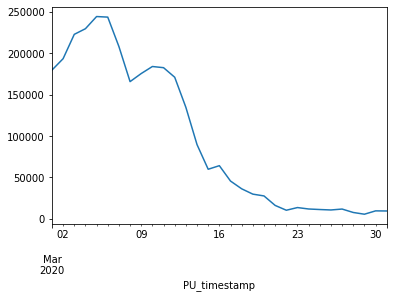

In [21]:
yellow_agg['ride_id'].plot()

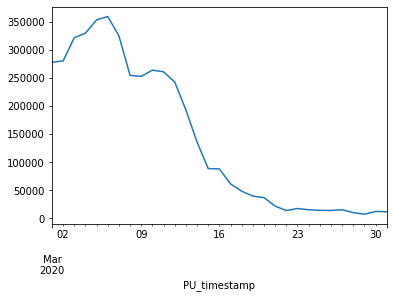

In [22]:
yellow_agg['passenger_count'].plot()

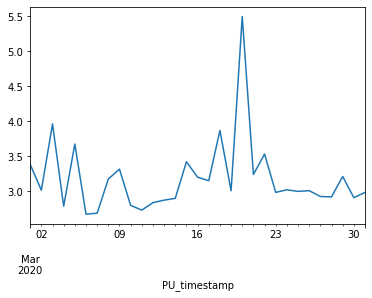

In [23]:
yellow_agg['trip_distance'].plot()

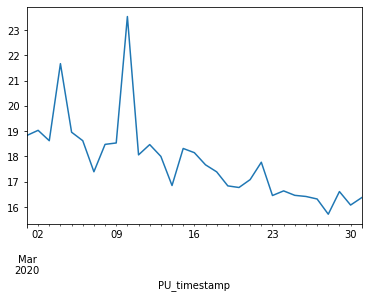

In [24]:
yellow_agg['total_amount'].plot()

Now change the frequency we used in the `Grouper` to some other option, use the same aggregation dictionary, slice to the dates we care about, and see how the results change.

Analyzing temporal data is much better with `Grouper` in our lives!

In [155]:
yellow_hourly_gb = yellow_df.groupby(pd.Grouper(key='PU_timestamp',freq='1M'))
yellow_hourly_agg = yellow_hourly_gb.agg(agg_d)
yellow_hourly_agg = yellow_hourly_agg['2020-03-01':'2020-03-31']

yellow_hourly_agg.head()

,ride_id,passenger_count,trip_distance,total_amount
PU_timestamp,,,,
2020-03-31,3006866,4357428.0,3.116789,18.841419


In [39]:
yellow_hourly_agg.tail()

,ride_id,passenger_count,trip_distance,total_amount
PU_timestamp,,,,
2020-03-31 19:00:00,469,551.0,3.043028,17.269531
2020-03-31 20:00:00,351,409.0,3.216097,17.557949
2020-03-31 21:00:00,228,246.0,3.382763,16.740789
2020-03-31 22:00:00,195,213.0,3.731333,18.660103
2020-03-31 23:00:00,179,202.0,4.323911,19.406089


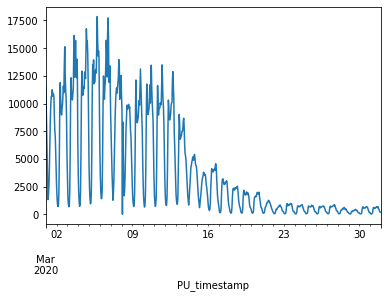

In [40]:
yellow_hourly_agg['ride_id'].plot()

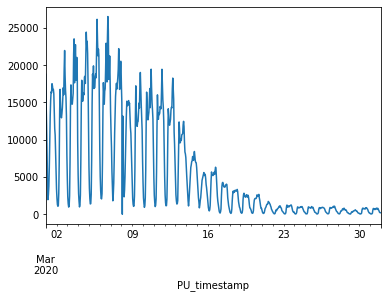

In [41]:
yellow_hourly_agg['passenger_count'].plot()

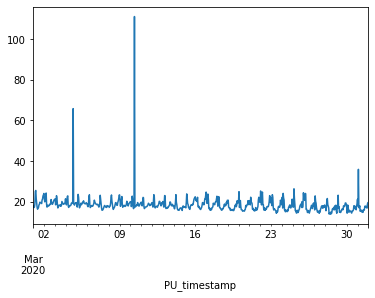

In [43]:
yellow_hourly_agg['total_amount'].plot()

## Temporal patterns

Temporal data is rarely random and uncorrelated and there are often consistent patterns in human and natural behavior that can be found at various frequencies. Identifying and understanding these underlying temporal patterns is crucial for a variety of data science tasks for describing behavior, characterizing anomalies, and forecasting future behavior. We'll use the NYC taxi, S&P 500, Wikipedia, and two new new datasets to illustrate these different types of temporal patterns.

| Dataset | Frequency |
| --- | --- |  
| `hourly_yellow_cab` | hour |
| `sp500_df` | daily |
| `wiki_cuboulder_pvs` | daily |
| `best_df` | monthly |
| `dia_passengers_df` | monthly |

The NYC taxi data is already loaded, so load the S&P 500 data.

In [45]:
sp500_df = pd.read_csv('sp500_close_volume.csv',parse_dates=['Date'])
sp500_df.set_index('Date',inplace=True)
sp500_df.tail()

,Adj Close,Volume
Date,,
2020-09-18,3319.469971,7068700000
2020-09-21,3281.060059,4828350000
2020-09-22,3315.570068,3963300000
2020-09-23,3236.919922,4364500000
2020-09-24,3246.590088,4599470000


Load some Wikipedia pageview data about the "University of Colorado Boulder" article.

In [46]:
import requests
from datetime import datetime
from urllib.parse import quote

def get_pageviews(page_title,endpoint='en.wikipedia.org',date_from='20150701',date_to='today'):
    """Takes Wikipedia page title and returns a all the various pageview records
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
        datefrom - a date string in a YYYYMMDD format, defaults to 20150701 (earliest date)
        dateto - a date string in a YYYYMMDD format, defaults to today
        
    Returns:
    s - a Series indexed by date with page views as values
    """
    if date_to == 'today':
        date_to = str(datetime.today().date()).replace('-','')
        
    quoted_page_title = quote(page_title, safe='')
    date_from = datetime.strftime(pd.to_datetime(date_from),'%Y%m%d')
    date_to = datetime.strftime(pd.to_datetime(date_to),'%Y%m%d')
    
    s = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{1}/{2}/{3}/{0}/daily/{4}/{5}".format(quoted_page_title,endpoint,'all-access','user',date_from,date_to)
    json_response = requests.get(s).json()
    
    if 'items' in json_response:
        df = pd.DataFrame(json_response['items'])
    else:
        raise KeyError('There is no "items" key in the JSON response.')
        
    df = df[['timestamp','views']]
    df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y%m%d%H')
    s = df.set_index('timestamp')['views']
        
    return s

In [47]:
wiki_cuboulder_pvs = get_pageviews('University of Colorado Boulder')
wiki_cuboulder_pvs.tail()

timestamp
2020-09-26    557
2020-09-27    532
2020-09-28    556
2020-09-29    583
2020-09-30    524
Name: views, dtype: int64

One new dataset is the [Berekley Earth Surface Temperature](http://berkeleyearth.org/) (BEST) data that captures the global temperature anomaly going back to 1750. This is 270 years of data available at a monthly resolution. The cleaned file is available on Canvas and the raw data is available [here](http://berkeleyearth.org/data-new/) as well as other kinds of data files.

In [3]:
best_df = pd.read_csv('berkeley_temps.csv',parse_dates=['Date'])
best_df.set_index('Date',inplace=True)
print(best_df.shape)
best_df.head()

(3248, 10)


,1M Anomaly,1M Uncertainty,1Y Anomaly,1Y Uncertainty,5Y Anomaly,5Y Uncertainty,10Y Anomaly,10Y Uncertainty,20Y Anomaly,20Y Uncertainty
Date,,,,,,,,,,
1750-01-01,-0.652,3.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1750-02-01,-1.223,4.059,-1.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1750-03-01,0.065,3.250,-1.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1750-04-01,-0.399,2.059,-1.108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1750-05-01,-1.838,3.638,-1.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
best_df.tail()

,1M Anomaly,1M Uncertainty,1Y Anomaly,1Y Uncertainty,5Y Anomaly,5Y Uncertainty,10Y Anomaly,10Y Uncertainty,20Y Anomaly,20Y Uncertainty
Date,,,,,,,,,,
2020-04-01,1.712,0.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,1.348,0.059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,1.204,0.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-01,1.206,0.084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,1.146,0.114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The other new dataset is the DIA passenger numbers that captures the number of passengers traveling through Denver International Airport every month going back to its Febraury 1995 opening through 2019.

In [93]:
den_passengers_df = pd.read_csv('den_passengers.csv',parse_dates=['Month'])
print(den_passengers_df.shape)
den_passengers_df.head()

(295, 11)


,Month,Total,American,Cargo,Delta,Frontier,Other,Southwest,United,United Express,Grand Total
0,1995-02-01,NaN,5833,0,4805,1434,8625,NaN,47230,2635,70562
1,1995-03-01,NaN,228196,0,200964,36703,245171,NaN,1962445,169190,2842669
2,1995-04-01,NaN,184229,0,157853,40050,191393,NaN,1724836,124351,2422712
3,1995-05-01,NaN,187990,0,162622,41403,171425,NaN,1833305,135800,2532545
4,1995-06-01,NaN,229348,0,198499,43754,186030,NaN,1975754,170033,2803418


In [94]:
den_passengers_df.tail()

,Month,Total,American,Cargo,Delta,Frontier,Other,Southwest,United,United Express,Grand Total
290,2019-03-01,NaN,278811,0,322828,555808,308881,1513364.0,1782858,688665,5451215
291,2019-04-01,NaN,246750,74,299488,571992,290865,1500926.0,1737985,673639,5321719
292,2019-05-01,NaN,283802,0,314251,792750,376223,1595557.0,1935794,743479,6041856
293,2019-06-01,NaN,291271,0,330620,821726,409370,1681044.0,2058467,794422,6386920
294,2019-07-01,NaN,297451,0,358448,879096,435666,1769875.0,2153501,839235,6733272


### Daily: Circadian rhythms

Most people in a given location sleep around the same time. When people are asleep, nothing much happens and this should be apparent in the data.

In [62]:
yellow_hourly_agg['hour'] = [i.hour for i in yellow_hourly_agg.index]
yellow_hourly_agg['weekday'] = [i.weekday() for i in yellow_hourly_agg.index]
yellow_hourly_agg.head()

,ride_id,passenger_count,trip_distance,total_amount,hour,weekday
PU_timestamp,,,,,,
2020-03-01 00:00:00,11627,18764.0,2.851881,17.935389,0,6
2020-03-01 01:00:00,9348,14796.0,2.679856,17.139431,1,6
2020-03-01 02:00:00,7352,11878.0,2.760121,17.036057,2,6
2020-03-01 03:00:00,5178,8183.0,2.837825,17.260900,3,6
2020-03-01 04:00:00,3026,4777.0,3.429514,18.772174,4,6


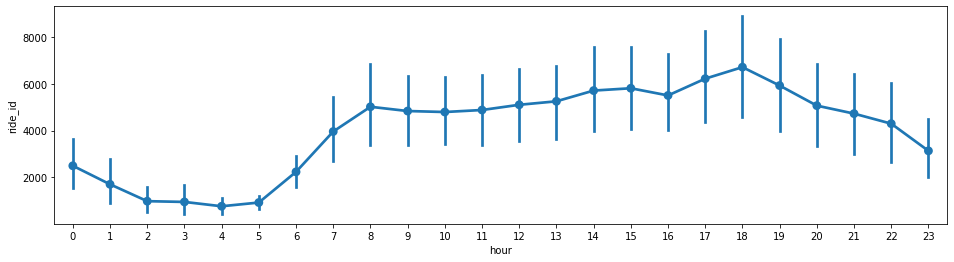

In [153]:
sb.pointplot(x='hour',
           y='ride_id',
           data=yellow_hourly_agg,
           aspect=3)

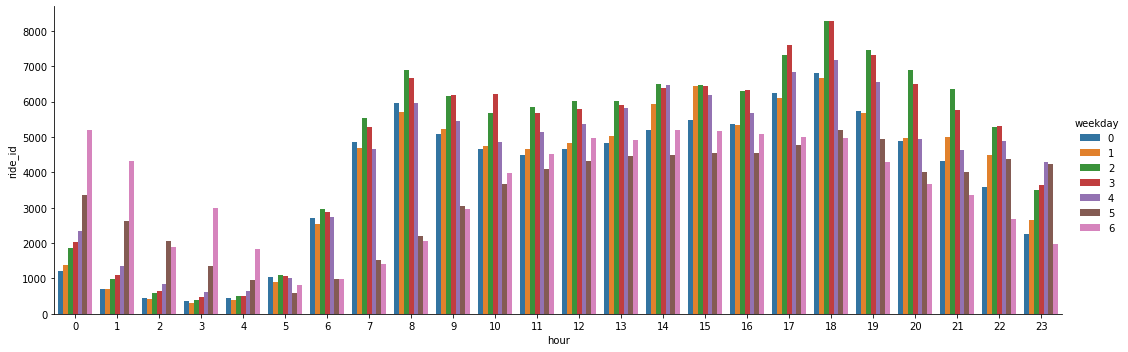

In [66]:
sb.catplot(x='hour',
           y='ride_id',
           hue='weekday',
           data=yellow_hourly_agg,
           ci=0,
           kind='bar',
           aspect=3)

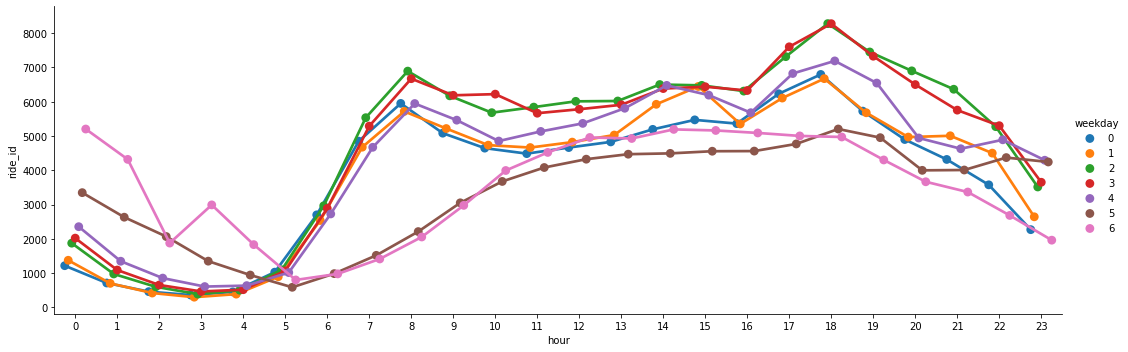

In [68]:
sb.catplot(x='hour',
           y='ride_id',
           hue='weekday',
           data=yellow_hourly_agg,
           ci=0,dodge=.5,
           kind='point',
           aspect=3)

### Weekly: Weekdays vs. weekends

Many people do not work on weekends and engage in other activities. The behavior of people on weekends is different than on weekdays.

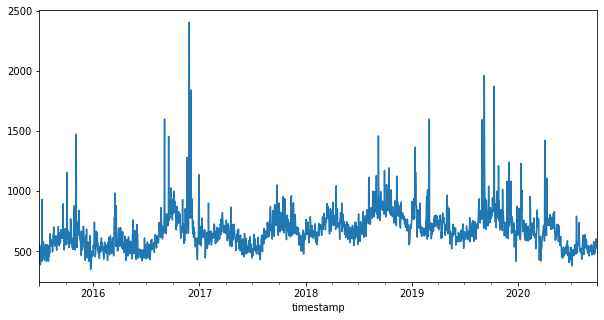

In [70]:
wiki_cuboulder_pvs.plot(figsize=(10,5))

In [73]:
wiki_cu_df = pd.DataFrame({'count':wiki_cuboulder_pvs})
wiki_cu_df['weekday'] = [i.weekday() for i in wiki_cu_df.index]

wiki_cu_df.head()

,count,weekday
timestamp,,
2015-07-01,563,2
2015-07-02,486,3
2015-07-03,424,4
2015-07-04,388,5
2015-07-05,407,6


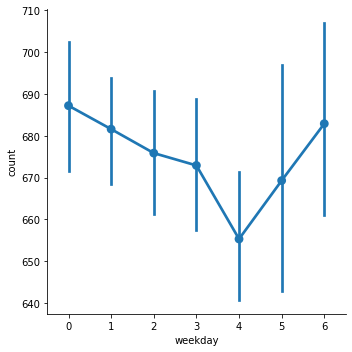

In [75]:
sb.catplot(x='weekday',y='count',data=wiki_cu_df,kind='point')

In [77]:
sp500_df['weekday'] = [i.weekday() for i in sp500_df.index]
sp500_df.head()

,Adj Close,Volume,weekday
Date,,,
2017-01-03,2257.830078,3770530000,1
2017-01-04,2270.750000,3764890000,2
2017-01-05,2269.000000,3761820000,3
2017-01-06,2276.979980,3339890000,4
2017-01-09,2268.899902,3217610000,0


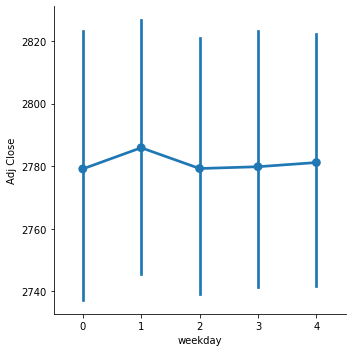

In [79]:
sb.catplot(x='weekday',y='Adj Close',data=sp500_df,kind='point')

### Yearly: Seasonality

The behavior of people during the summer is different than the behavior of people during the winter.

In [81]:
wiki_cu_df['month'] = [i.month for i in wiki_cu_df.index]
wiki_cu_df.head()

,count,weekday,month
timestamp,,,
2015-07-01,563,2,7
2015-07-02,486,3,7
2015-07-03,424,4,7
2015-07-04,388,5,7
2015-07-05,407,6,7


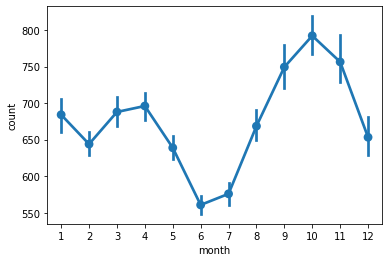

In [82]:
sb.pointplot(x='month',y='count',data=wiki_cu_df)

In [84]:
sp500_df['month'] = [i.month for i in sp500_df.index]
sp500_df.head()

,Adj Close,Volume,weekday,month
Date,,,,
2017-01-03,2257.830078,3770530000,1,1
2017-01-04,2270.750000,3764890000,2,1
2017-01-05,2269.000000,3761820000,3,1
2017-01-06,2276.979980,3339890000,4,1
2017-01-09,2268.899902,3217610000,0,1


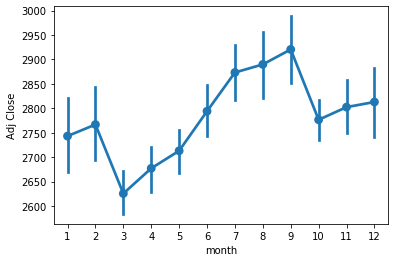

In [85]:
sb.pointplot(x='month',y='Adj Close',data=sp500_df)

In [87]:
best_df['month'] = [i.month for i in best_df.index]
best_df.head()

,1M Anomaly,1M Uncertainty,1Y Anomaly,1Y Uncertainty,5Y Anomaly,5Y Uncertainty,10Y Anomaly,10Y Uncertainty,20Y Anomaly,20Y Uncertainty,month
Date,,,,,,,,,,,
1750-01-01,-0.652,3.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1750-02-01,-1.223,4.059,-1.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1750-03-01,0.065,3.250,-1.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1750-04-01,-0.399,2.059,-1.108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1750-05-01,-1.838,3.638,-1.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


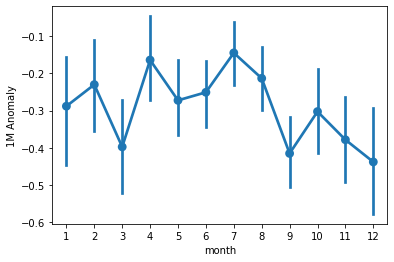

In [90]:
sb.pointplot(x='month',y='1M Anomaly',data=best_df)

In [97]:
den_passengers_df.set_index('Month',inplace=True)
den_passengers_df.head()

,Total,American,Cargo,Delta,Frontier,Other,Southwest,United,United Express,Grand Total
Month,,,,,,,,,,
1995-02-01,NaN,5833,0,4805,1434,8625,NaN,47230,2635,70562
1995-03-01,NaN,228196,0,200964,36703,245171,NaN,1962445,169190,2842669
1995-04-01,NaN,184229,0,157853,40050,191393,NaN,1724836,124351,2422712
1995-05-01,NaN,187990,0,162622,41403,171425,NaN,1833305,135800,2532545
1995-06-01,NaN,229348,0,198499,43754,186030,NaN,1975754,170033,2803418


In [98]:
den_passengers_df['m'] = [i.month for i in den_passengers_df.index ]
den_passengers_df.head()

,Total,American,Cargo,Delta,Frontier,Other,Southwest,United,United Express,Grand Total,m
Month,,,,,,,,,,,
1995-02-01,NaN,5833,0,4805,1434,8625,NaN,47230,2635,70562,2
1995-03-01,NaN,228196,0,200964,36703,245171,NaN,1962445,169190,2842669,3
1995-04-01,NaN,184229,0,157853,40050,191393,NaN,1724836,124351,2422712,4
1995-05-01,NaN,187990,0,162622,41403,171425,NaN,1833305,135800,2532545,5
1995-06-01,NaN,229348,0,198499,43754,186030,NaN,1975754,170033,2803418,6


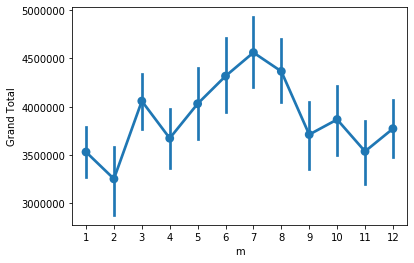

In [100]:
sb.pointplot(x='m',y='Grand Total',data=den_passengers_df)

### Super-annual: Events

There are often major events every few years (elections, sporting events, *etc*.) and people's behavior during those years is different.

### Bursts

Finally, there are major pulses or surges of activity unrelated to regular temporal patterns. Disruptions like disasters, accidents, and other current events can be unexpected while other events like championships or elections can be predicted.

In [101]:
clinton_pvs = get_pageviews('Hillary Clinton')
clinton_pvs.tail()

timestamp
2020-09-26     6666
2020-09-27     7321
2020-09-28     7713
2020-09-29     9418
2020-09-30    25937
Name: views, dtype: int64

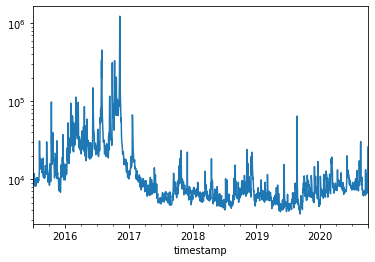

In [103]:
ax = clinton_pvs.plot()
ax.set_yscale('log')

In [104]:
trump_pvs = get_pageviews('Donald Trump')
trump_pvs.tail()

timestamp
2020-09-26     51934
2020-09-27     58341
2020-09-28     74250
2020-09-29     87333
2020-09-30    311047
Name: views, dtype: int64

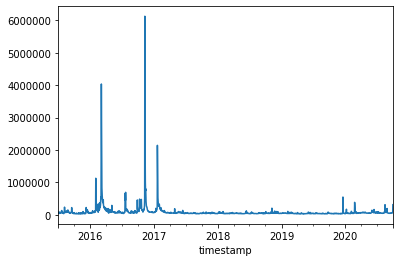

In [106]:
ax = trump_pvs.plot()
# ax.set_yscale('log')

## Autocorrelation

A time series is rarely a completely random: the values today tend to be similar to the values yesterday and will be similar to the values tomorrow. The fancy statistical term for this is *autocorrelation* meaning that a time series is correlated with itself. We can detect auto-correlation by examining the correlation between values at one period to adjacent periods.

In class 17, we used `.shift()` to delay or advance time series by one period. Let's `shift` one of the time series and correlate the original values with the shifted values.

In [108]:
yellow_agg['ride_id']

PU_timestamp
2020-03-01    179723
2020-03-02    193508
2020-03-03    222917
2020-03-04    229734
2020-03-05    244448
2020-03-06    243741
2020-03-07    208190
2020-03-08    165787
2020-03-09    175564
2020-03-10    184060
2020-03-11    182630
2020-03-12    171077
2020-03-13    134702
2020-03-14     89650
2020-03-15     59871
2020-03-16     64201
2020-03-17     45617
2020-03-18     36244
2020-03-19     29803
2020-03-20     27622
2020-03-21     16166
2020-03-22     10340
2020-03-23     13576
2020-03-24     11851
2020-03-25     11205
2020-03-26     10663
2020-03-27     11778
2020-03-28      7633
2020-03-29      5540
2020-03-30      9579
2020-03-31      9446
Freq: D, Name: ride_id, dtype: int64

In [112]:
from scipy.stats import pearsonr

In [118]:
np.corrcoef(yellow_agg['ride_id'],yellow_agg['ride_id'].shift(-1).fillna(0))

array([[1.        , 0.98182443],
       [0.98182443, 1.        ]])

In [114]:
pearsonr(yellow_agg['ride_id'],yellow_agg['ride_id'].shift(1).fillna(0))

(0.912279108337124, 9.153252821931065e-13)

In [120]:
np.corrcoef(wiki_cuboulder_pvs,wiki_cuboulder_pvs.shift(1).fillna(0))

array([[1.        , 0.62913818],
       [0.62913818, 1.        ]])

In [124]:
np.corrcoef(best_df['1M Anomaly'].fillna(0),best_df['1M Anomaly'].shift(1).fillna(0))

array([[1.        , 0.54193066],
       [0.54193066, 1.        ]])

pandas has a function [`.autocorr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.autocorr.html) that will do this for us instead with different lag parameters. Let's try it out.

In [16]:
yellow_agg['ride_id'].autocorr(1)

NameError: name 'yellow_agg' is not defined

In [136]:
wiki_cuboulder_pvs.autocorr(10)

0.4381691899945492

In [125]:
best_df['1M Anomaly'].autocorr(1)

0.5423950543546968

Rather than doing this for a number of different lag parameters, we can visualize the correlation across a larger range of lags. The visualization function for this is under [`plotting.autocorrelation_plot()`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html).

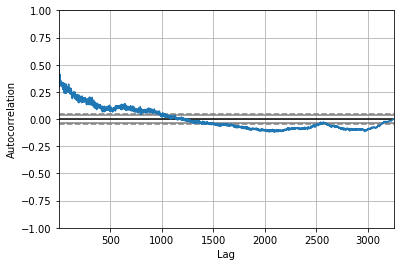

In [138]:
pd.plotting.autocorrelation_plot(best_df['1M Anomaly'].fillna(0))

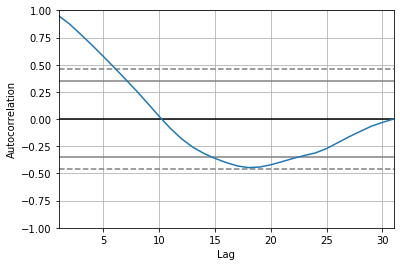

In [139]:
pd.plotting.autocorrelation_plot(yellow_agg['ride_id'])

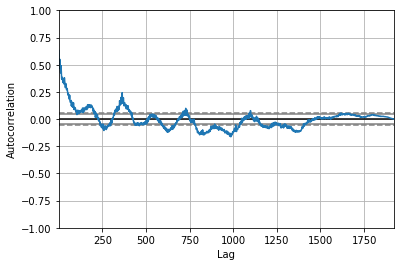

In [140]:
pd.plotting.autocorrelation_plot(wiki_cuboulder_pvs)

This cal also be plotted with [`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) function in statsmodels.

In [141]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

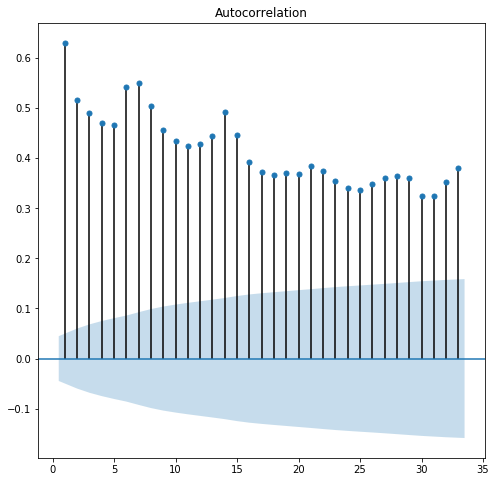

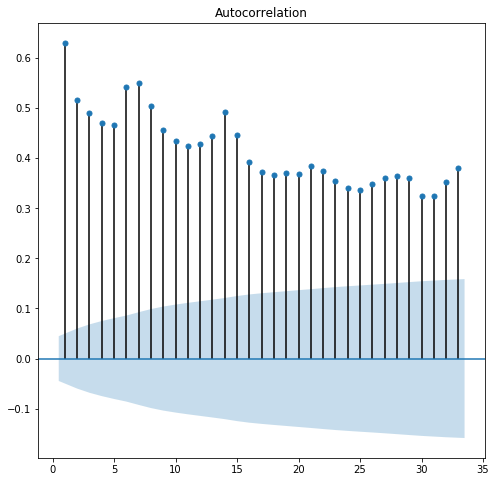

In [142]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plot_acf(wiki_cuboulder_pvs,ax=ax,zero=False)

## Additive models

A popular way of representing time series data is to decompose the observed data into three components.

* **Trend** - A medium-to-long term component capturing a tendency for the data to increase or decrease.
* **Seasonal** - Regular periods in the data corresponding to daily, weekly, monthly, etc. signals.
* **Residual** - The data "left over" that isn't explained by the trend or the seasonal signals.

Here we will use a package called `statsmodels` we haven't used before that should (hopefully!) come with your Anaconda distribution. It has a pandas-friendly function called [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) that will generate a visualization of the trend, seasonal, and residual patterns in your time series data.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose 

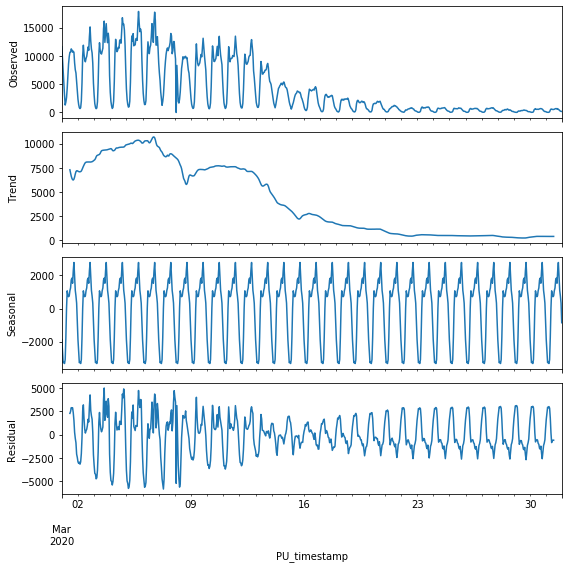

In [146]:
d = seasonal_decompose(yellow_hourly_agg['ride_id'])

plt.rcParams["figure.figsize"] = (8,8)
f = d.plot()

<AxesSubplot:xlabel='Date'>

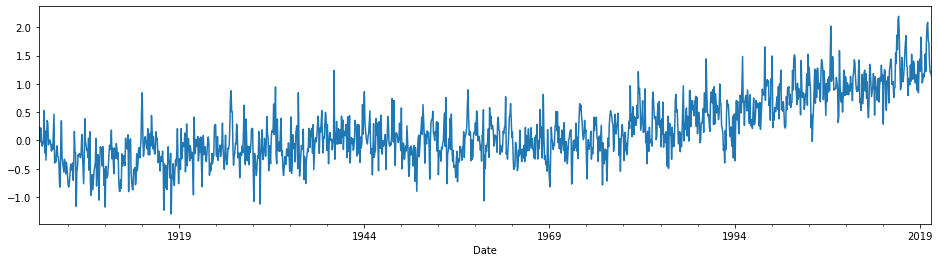

In [10]:
best_df['1M Anomaly'].loc['1900-01-01':].fillna(0).plot()

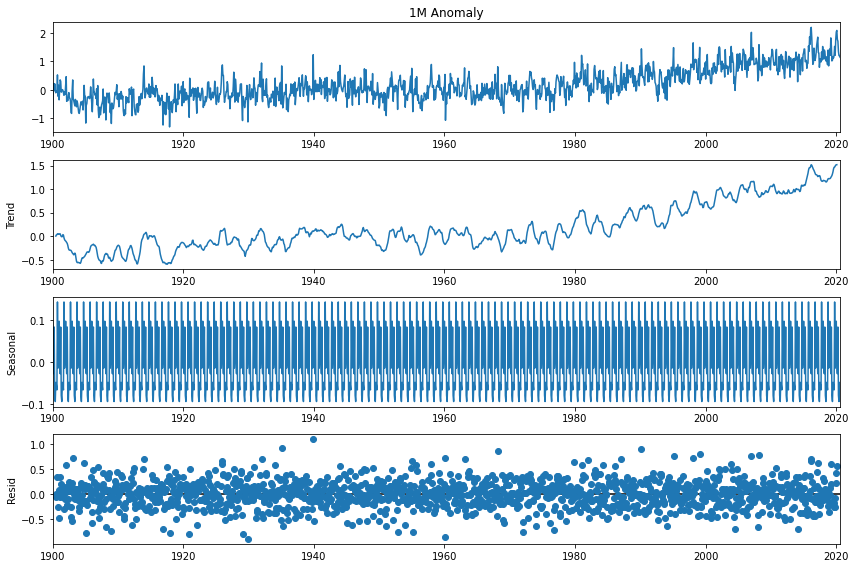

In [15]:
d = seasonal_decompose(best_df['1M Anomaly'].loc['1900-01-01':].fillna(0))

plt.rcParams["figure.figsize"] = (12,8)
f = d.plot()

In [151]:
den_passengers_df['Grand Total'].index

DatetimeIndex(['1995-02-01', '1995-03-01', '1995-04-01', '1995-05-01',
               '1995-06-01', '1995-07-01', '1995-08-01', '1995-09-01',
               '1995-10-01', '1995-11-01',
               ...
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01'],
              dtype='datetime64[ns]', name='Month', length=295, freq=None)

In [149]:
d = seasonal_decompose(den_passengers_df['Grand Total'])

plt.rcParams["figure.figsize"] = (16,4)
f = d.plot()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None

## Appendix

### Cleaning the BEST data

Raw data: http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_complete.txt  
Documentation: http://berkeleyearth.org/data-new/

In [ ]:
best_df = pd.read_csv('best_202009.csv')
best_df['Date'] = pd.period_range(start='1750-01',end='2020-08',freq='1M')
best_df.drop(columns=['Year','Month'],inplace=True)
best_df.set_index('Date',inplace=True)
best_df.to_csv('berkeley_temps.csv',encoding='utf8')
best_df.head()